In [95]:
import sys
import warnings
warnings.filterwarnings("ignore")
sys.path.append('/Users/hx/Documents/GitHub/model-catalyst/research/vos/')
import numpy as np

import keras.utils
from keras.layers import Input,Dense, Flatten
from keras.models import load_model, Model, Sequential, save_model
from keras.layers import Conv2D, UpSampling2D, AveragePooling2D, Concatenate, LeakyReLU,Reshape,concatenate
from keras.datasets import mnist
from keras import backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython import display
import timed

In [96]:
# K.tensorflow_backend._get_available_gpus()

### helper functions

In [97]:
def generateTheta(L,endim):
    # This function generates L random samples from the unit `ndim'-u
    theta=[w/np.sqrt((w**2).sum()) for w in np.random.normal(size=(L,endim))]
    return np.asarray(theta) # shape: (L, endim)

# def generateZ():
#     # This function generates 2D samples from a `circle' distribution in 
#     # a 2-dimensional space
#     r=np.random.uniform(size=())
#     theta=2*np.pi*np.random.uniform(size=())
#     x=r*np.cos(theta)
#     y=r*np.sin(theta)
#     z_=np.array([x,y]).T
#     return z_ #shape: (2,)

def generateZ(endim):
    z=np.random.normal(0,1,size=(endim))
    return z #shape:(endim,)
    
def generateZ_majority(endim):
    # For majority class samples i.e. non-zero digits
    # This function generates samples from a uniform distribution in 
    # the `endim'-dimensional space
    z=2*(np.random.uniform(size=(endim))-0.5)
    return z #shape:(endim,)


def genZ(endim,y,y_0=0):
    #default 0 as the minority class
    if y==y_0:
        return generateZ(endim)
    else:
        return generateZ_majority(endim)
    
def stitchImages(I,axis=0):
    n,N,M,K=I.shape
    if axis==0:
        img=np.zeros((N*n,M,K))
        for i in range(n):
            img[i*N:(i+1)*N,:,:]=I[i,:,:,:]
    else:
        img=np.zeros((N,M*n,K))
        for i in range(n):
            img[:,i*M:(i+1)*M,:]=I[i,:,:,:]
    return img

### load data

In [98]:
(x_train,y_train),(x_test,y_test)=mnist.load_data()

#TODO: delete
x_train = x_train[:100]
y_train = y_train[:100]
x_test = x_test[:100]
y_test = y_test[:100]

x_train=np.expand_dims(x_train.astype('float32')/255.,3)
x_test=np.expand_dims(x_test.astype('float32')/255.,3)

In [99]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([13, 14,  6, 11, 11,  5, 11, 10,  8, 11]))

In [100]:
x_train.shape # 60000 pictures; each pic is 28*28*1

(100, 28, 28, 1)

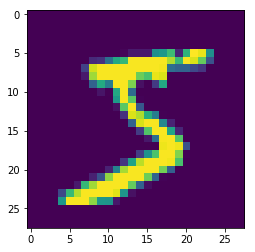

In [101]:
plt.imshow(np.squeeze(x_train[0,...]))
plt.show()

### parameters defined here

In [102]:
img=Input((28,28,1)) #Input image 
y_img=Input((1,)) # Input image label
interdim=128 # This is the dimension of intermediate latent variable 
             #(after convolution and before embedding)

endim=20 # Dimension of the embedding space
embedd=Input((endim,)) #Keras input to Decoder
depth=16 # This is a design parameter and in fact it is not the depth!
L=50 # Number of random projections
batchsize=5 #TODO: change

### Encoder

In [103]:
x=Conv2D(filters=depth*1, kernel_size=(3, 3), padding='same')(img)
x=LeakyReLU(alpha=0.2)(x)
# x=BatchNormalization(momentum=0.8)(x)
x=Conv2D(depth*1, (3, 3), padding='same')(x)
x=LeakyReLU(alpha=0.2)(x)
# x=BatchNormalization(momentum=0.8)(x)
x=AveragePooling2D((2, 2), padding='same')(x)
x=Conv2D(depth*2, (3, 3), padding='same')(x)
x=LeakyReLU(alpha=0.2)(x)
# x=BatchNormalization(momentum=0.8)(x)
x=Conv2D(depth*2, (3, 3), padding='same')(x)
x=LeakyReLU(alpha=0.2)(x)
# x=BatchNormalization(momentum=0.8)(x)
x=AveragePooling2D((2, 2), padding='same')(x)
x=Conv2D(depth*4, (3, 3), padding='same')(x)
x=LeakyReLU(alpha=0.2)(x)
# x=BatchNormalization(momentum=0.8)(x)
x=Conv2D(depth*4, (3, 3), padding='same')(x)
x=LeakyReLU(alpha=0.2)(x)
# x=BatchNormalization(momentum=0.8)(x)
x=AveragePooling2D((2, 2), padding='same')(x)
x=Flatten()(x)
x=concatenate([x, y_img],axis=1) 
x=Dense(interdim,activation='relu')(x)
encoded=Dense(endim)(x)
encoder=Model(inputs=[img, y_img],outputs=[encoded])
# encoder.summary()

## Decoder

In [104]:
x=Dense(interdim)(embedd)
x=Dense(depth*64,activation='relu')(x)
# x=BatchNormalization(momentum=0.8)(x)
x=Reshape((4,4,4*depth))(x)
x=UpSampling2D((2, 2))(x)
x=Conv2D(depth*4, (3, 3), padding='same')(x)
x=LeakyReLU(alpha=0.2)(x)
# x=BatchNormalization(momentum=0.8)(x)
x=Conv2D(depth*4, (3, 3), padding='same')(x)
x=LeakyReLU(alpha=0.2)(x)
x=UpSampling2D((2, 2))(x)
x=Conv2D(depth*4, (3, 3), padding='valid')(x)
x=LeakyReLU(alpha=0.2)(x)
# x=BatchNormalization(momentum=0.8)(x)
x=Conv2D(depth*4, (3, 3), padding='same')(x)
x=LeakyReLU(alpha=0.2)(x)
x=UpSampling2D((2, 2))(x)
x=Conv2D(depth*2, (3, 3), padding='same')(x)
x=LeakyReLU(alpha=0.2)(x)
# x=BatchNormalization(momentum=0.8)(x)
x=Conv2D(depth*2, (3, 3), padding='same')(x)
x=LeakyReLU(alpha=0.2)(x)
# x=BatchNormalization(momentum=0.8)(x)
# x=BatchNormalization(momentum=0.8)(x)
decoded=Conv2D(1, (3, 3), padding='same',activation='sigmoid')(x)

decoder=Model(inputs=[embedd, y_img],outputs=[decoded])
# decoder.summary()

In [105]:
# Generate the autoencoder by combining encoder and decoder
aencoded=encoder([img,y_img])
ae=decoder([aencoded, y_img])
autoencoder=Model(inputs=[img,y_img],outputs=[ae])
# autoencoder.summary()

In [106]:
theta=K.variable(np.zeros(shape=(L,endim))) #placeholder for theta
z=K.variable(np.zeros(shape=(batchsize,endim))) #placeholder for z
# Let projae be the projection of the encoded samples
projae=K.dot(aencoded,K.transpose(theta))
# Let projz be the projection of the $q_Z$ samples
projz=K.dot(z,K.transpose(theta))
# Calculate the Sliced Wasserstein distance by sorting 
# the projections and calculating the L2 distance between
W2=(tf.nn.top_k(tf.transpose(projae),k=batchsize).values-tf.nn.top_k(tf.transpose(projz),k=batchsize).values)**2

w2weight=K.variable(10.0)
alpha_y=K.variable(1.0)
crossEntropyLoss=(1.0)*K.mean(K.binary_crossentropy(K.flatten(img),K.flatten(ae)))
L1Loss=(1.0)*K.mean(K.abs(K.flatten(img)-K.flatten(ae)))
W2Loss=w2weight*K.mean(W2)
# I have a combination of L1 and Cross-Entropy loss for the first term and then 
# W2 for the second terms
vae_Loss=(L1Loss+crossEntropyLoss)*alpha_y+W2Loss
autoencoder.add_loss(vae_Loss) # Add the custom loss to the model
#Compile the model
autoencoder.compile(optimizer='rmsprop')

In [107]:
# def conv_cond_concat(x, y):
#     """Concatenate conditioning vector on feature map axis."""
#     x_shapes = x.get_shape()
#     y_shapes = y.get_shape()
#     return concat([x, y*tf.ones([x_shapes[0], x_shapes[1], x_shapes[2], y_shapes[3]])], 3)

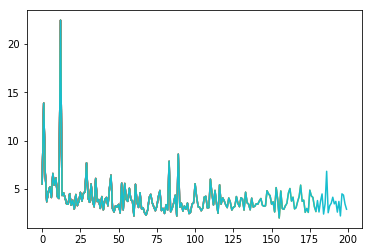

In [108]:
loss=[]
fig1=plt.figure()
for epoch in range(10):
    print("epoch:", epoch)
    ind=np.random.permutation(x_train.shape[0])    
    if epoch>10:
        K.set_value(w2weight,1.1*K.eval(w2weight))
    for i in range(int(x_train.shape[0]/batchsize)):
        Xtr=x_train[ind[i*batchsize:(i+1)*batchsize],...]
        Ytr=y_train[ind[i*batchsize:(i+1)*batchsize],...]
        theta_=generateTheta(L,endim)
        z_=np.array([genZ(endim, yi) for yi in Ytr])
        K.set_value(z,z_)
        K.set_value(theta,theta_)        
        loss.append(autoencoder.train_on_batch(x=[Xtr,Ytr],y=None))        
    plt.plot(np.asarray(loss))
    display.clear_output(wait=True)
    display.display(plt.gcf())

In [109]:
# for zero digits we use generateZ(endim)
# only sample from zero y
y_train0 = y_train[np.where((y_train == 0))]
en=np.array([genZ(endim, yi) for yi in y_train0])
dec=decoder.predict([en, y_train0])

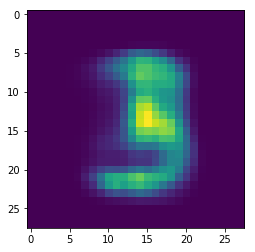

In [111]:
plt.imshow(np.squeeze(dec[4,...]))
plt.show()

In [75]:
newy = np.concatenate((np.zeros(13), y_train), axis=0)

In [76]:
newx = np.concatenate((dec.reshape(13,784), x_train.reshape(100, 784)), axis=0)

In [78]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_score, recall_score, precision_recall_fscore_support
rf_clf = RandomForestClassifier(
        random_state = 2019,
        n_jobs = -1
        )
model = rf_clf.fit(newx, np.array(newy.tolist()))

In [80]:
y_pred = model.predict(x_test.reshape(100,784))
precision, recall, f1, support = \
            precision_recall_fscore_support(y_true=y_test, y_pred=y_pred, beta=1, average=None)
print(recall)
print(precision)
print(f1)

[0.875      0.92857143 0.25       0.63636364 0.85714286 0.
 0.6        0.8        0.         0.36363636]
[0.58333333 0.86666667 0.4        0.7        0.52173913 0.
 0.6        0.92307692 0.         0.57142857]
[0.7        0.89655172 0.30769231 0.66666667 0.64864865 0.
 0.6        0.85714286 0.         0.44444444]


### Encode and decode Xtrain

In [14]:
en=encoder.predict([x_train, y_train])# Encode the images
dec=decoder.predict([en,y_train]) # Decode the encodings

In [16]:
en.shape

(100, 20)

### Define the SWAE loss

In [ ]:
# swae_loss(1.0)

In [ ]:
#shape of W2: (L, batchsize)

## Train

In [ ]:
# save_model(encoder,filepath='/Users/hx/Documents/test/WOS/MNIST_encoder.h5')
# save_model(decoder,filepath='/Users/hx/Documents/test/WOS/MNIST_decoder.h5')
# save_model(autoencoder,filepath='/Users/hx/Documents/test/WOS/MNIST_autoencoder.h5')

In [ ]:
#### Testing on TESTING DATA ZERO DIGITS ##################
# Test autoencoder
en=encoder.predict([x_test, y_test])# Encode the images
dec=decoder.predict([en,y_test]) # Decode the encodings

# select all zero digits from the training dataset
test_filter = np.where((y_test == 0))
x_test0, y_test0, dec_0 = x_test[test_filter], y_test[test_filter], dec[test_filter]
# Sanity check
# considering increase endim to get better reconstructions
fig, [ax1,ax2]=plt.subplots(2,1,figsize=(10,5))
# examine the first 10 imgs
I_temp=(stitchImages(x_test0[:15],1)*255.0).astype('uint8')
Idec_temp=(stitchImages(dec_0[:15],1)*255.0).astype('uint8')
ax1.imshow(np.squeeze(I_temp));
ax1.set_xticks([])
ax1.set_yticks([])
ax2.imshow(np.squeeze(Idec_temp));
ax2.set_xticks([])
ax2.set_yticks([])
plt.show()

In [ ]:
# select all zero digits from the training dataset
train_filter = np.where((y_train == 0))
x_train0, y_train0, dec_0 = x_train[train_filter], y_train[train_filter], dec[train_filter]

In [ ]:
# Sanity check
# considering increase endim to get better reconstructions
fig, [ax1,ax2]=plt.subplots(2,1,figsize=(10,5))
# examine the first 10 imgs
I_temp=(stitchImages(x_train0[:15],1)*255.0).astype('uint8')
Idec_temp=(stitchImages(dec_0[:15],1)*255.0).astype('uint8')
ax1.imshow(np.squeeze(I_temp));
ax1.set_xticks([])
ax1.set_yticks([])
ax2.imshow(np.squeeze(Idec_temp));
ax2.set_xticks([])
ax2.set_yticks([])
plt.show()

In [ ]:
s3_client.write_image(plt, 'holly/zeros.png')

In [ ]:
Nsample = 25
randomSamples=generateZ(Nsample**2)
print(randomSamples.shape)
some_y = np.repeat(7, Nsample**2) # digit 7
randomdecodeimg=np.squeeze(decoder.predict([randomSamples, some_y]))
print(randomdecodeimg.shape)

In [ ]:
imgRandom=np.zeros((Nsample*28,Nsample*28))
count=0
for i in range(Nsample):
    for j in range(Nsample):        
        imgRandom[i*28:(i+1)*28,j*28:(j+1)*28]=randomdecodeimg[count,...]
        count+=1

In [ ]:
fig=plt.figure(figsize=(10,10))
plt.imshow(imgRandom,cmap='gray')
plt.show()

## S3

In [ ]:
import sys
sys.path.append('/home/ubuntu/holly/vos/')

In [ ]:
from awsHelper.s3client import S3Client
s3_client = S3Client(bucket = 'integrate-ai-research-staging')
s3_client.write_image(plt, 'holly/temp.png')